In [1]:
cd ../src

/workspace/Script/NLP/PII/src


In [2]:
import os
import gc
import sys
import json
import time
import torch
import joblib
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
import re
import os
import gc
import math
import time
import json
import random
import numpy as np
import pandas as pd
import wandb

from pathlib import Path

import torch 
import torch.nn as nn
from torch.cuda import amp
import torch.optim as optim
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel, AutoConfig
 
from data.data_utils import to_gpu,to_np
from data.dataset import FeedbackDataset,CustomCollator
from torch.utils.data import DataLoader

from model_zoo.models import FeedbackModel,span_nms,aggregate_tokens_to_words
from metrics_loss.metrics import score_feedback,score,pii_fbeta_score_v2,compute_metrics
from transformers import get_linear_schedule_with_warmup,get_cosine_schedule_with_warmup,get_polynomial_decay_schedule_with_warmup,get_cosine_with_hard_restarts_schedule_with_warmup

from sklearn.metrics import log_loss 
from tqdm.auto import tqdm

from utils.utils import count_parameters
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Params

In [5]:
data_path = Path(r"/database/kaggle/PII/data")
os.listdir(data_path)

['train.json', 'test.json', 'sample_submission.csv']

In [6]:
CHECKPOINT_PATH = Path(r"/database/kaggle/PII/checkpoint")

In [7]:
df = pd.read_json(data_path/'train.json')
df.shape

(6807, 5)

In [8]:
df.head(2)

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."


In [9]:
from sklearn.model_selection import GroupKFold,StratifiedGroupKFold,KFold,StratifiedKFold

In [10]:
df['has_label'] = (df['labels'].transform(lambda x:len([i for i in x if i!="O" ]))>0)*1
seeds = [42]
folds_names = []
for K in [5]:  
    for seed in seeds:
        mskf = StratifiedKFold(n_splits=K,shuffle=True,random_state=seed)
        name = f"fold_sk_{K}_seed_{seed}"
        df[name] = -1
        for fold, (trn_, val_) in enumerate(mskf.split(df,df['has_label'])):
            df.loc[val_, name] = fold

In [10]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [11]:
LABEL2TYPE = ('NAME_STUDENT','EMAIL','USERNAME','ID_NUM', 'PHONE_NUM','URL_PERSONAL','STREET_ADDRESS','O')
for name in LABEL2TYPE[:-1]:
    df[name] = ((df['labels'].transform(lambda x:len([i for i in x if i.split('-')[-1]==name ])))>0)*1

seeds = [42]
folds_names = []
for K in [5]:  
    for seed in seeds:
        mskf = MultilabelStratifiedKFold(n_splits=K,shuffle=True,random_state=seed)
        name = f"fold_msk_{K}_seed_{seed}"
        df[name] = -1
        for fold, (trn_, val_) in enumerate(mskf.split(df,df[list(LABEL2TYPE)[:-1]])):
            df.loc[val_, name] = fold

# Data

In [12]:
from train_utils import inference_step
from types import SimpleNamespace

In [23]:
ID_TYPE = {"0-0":0,"0-1":1,
           "1-0":2,"1-1":3,
           "2-0":4,"2-1":5,
           "3-0":6,"3-1":7,
           "4-0":8,"4-1":9,
           "5-0":10,"5-1":11,
           "6-0":12,"6-1":12
          }
ID_NAME = {"0-0":"B-NAME_STUDENT","0-1":"I-NAME_STUDENT",
           "1-0":"B-EMAIL","1-1":"I-EMAIL",
           "2-0":"B-USERNAME","2-1":"I-USERNAME",
           "3-0":"B-ID_NUM","3-1":"I-ID_NUM",
           "4-0":"B-PHONE_NUM","4-1":"I-PHONE_NUM",
           "5-0":"B-URL_PERSONAL","5-1":"I-URL_PERSONAL",
           "6-0":"B-STREET_ADDRESS","6-1":"I-STREET_ADDRESS"
          }

def inference_steps(df,folder,bs=1,fold=0):
    
    # ==== Loading Args =========== #
    f = open(f'{folder}/params.json')
    args = json.load(f)
    args = SimpleNamespace(**args)
    args.val_loader['batch_size'] = bs
    args.model['pretrained_tokenizer'] = f"{folder}/tokenizer"
    args.model['model_params']['config_path'] = f"{folder}/config.pth"
    args.model['pretrained_weights'] = None
    args.model["model_params"]['pretrained_path'] = None
#     args.model["model_params"]['max_len'] = 3048
    
    args.device = 1
    f.close()
    device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
    
    # ==== Loading dataset =========== #
    tokenizer = AutoTokenizer.from_pretrained(args.model["model_params"]['model_name'])
    valid_dataset = eval(args.dataset)(df,tokenizer,**args.data["params_valid"])
    
    
    
    # ==== Loading checkpoints =========== #
    checkpoints = [x.as_posix() for x in (Path(folder)).glob("*.pth") if f"fold_{fold}" in x.as_posix()]
    print(checkpoints)
    weights = [1/len(checkpoints)]*len(checkpoints)
    
    
    # ==== Loop Inference =========== #
    doc_ids = []
    tokens = []
    predictions = None
    gt_df = []
    for j,(checkpoint,weight) in enumerate(zip(checkpoints,weights)):
        net = FeedbackModel(**args.model["model_params"])
        net.load_state_dict(torch.load(checkpoint, map_location=lambda storage, loc: storage))
        net = net.to(device)
        net.eval()
        
        collator = CustomCollator(tokenizer,net)
        val_loader = DataLoader(valid_dataset,**args.val_loader,collate_fn=collator)
    

        
        preds = []
        
        with torch.no_grad():
            for data in tqdm(val_loader):
                data = to_gpu(data, device)
                
                pred = net(data)
                preds.append(pred.detach().cpu())
#                 pred  = pred.softmax(-1)
                
                
                if j==0:
                
                    doc_ids+=[data['text_id']]*pred.shape[0]
                    tokens+=np.arange(pred.shape[0]).tolist()
                    
                    data = to_np(data)
                    gt = pd.DataFrame({
                                      "document":data['text_id'],
                                      "token":np.arange(pred.shape[0]),
                                      "label":data["gt_spans"][:,1],
                                      "I":data["gt_spans"][:,2],
                                     })
                    gt_df.append(gt)

        
        if predictions is not None:
#             predictions = torch.max(predictions,torch.cat(preds,dim=0))
            predictions+= torch.cat(preds,dim=0)*weight
        else:
            predictions = torch.cat(preds,dim=0)*weight
#             predictions+= torch.cat(preds,dim=0)*weight
        print(predictions.shape)
    
    predictions = predictions.softmax(-1)
    s,i = predictions[:,:-1].max(-1)
    pred_df = pd.DataFrame({"document":doc_ids,
                                 "token" : tokens,
                                 "label" : i.numpy() ,
                                 "score" : s.numpy() ,
                                 "o_score":predictions[:,-1].numpy()
                                 })
    
    # ==== Loop Inference =========== #
    del valid_dataset
    del val_loader
    del net
    del s,i
    del predictions

    gc.collect()
#     torch.cuda.empty_cache()
    
    # ==== Loop Inference =========== #
#     pred_df = pred_df[(pred_df.label!=7) & (pred_df.score>0.5)].reset_index(drop=True)
#     pred_df["I"] = ((pred_df.groupby('document')['label'].transform(lambda x:x.diff())==0) & (pred_df.groupby('document')['token'].transform(lambda x:x.diff())==1))*1
#     pred_df['labels'] = pred_df['label'].astype(str)+'-'+pred_df['I'].astype(str)
#     pred_df["label_pred"] = pred_df["labels"].map(ID_TYPE).fillna(0).astype(int)
#     pred_df['row_id'] = np.arange(len(pred_df))
    

    gt_df = pd.concat(gt_df,axis=0).reset_index(drop=True)
    gt_df = gt_df[gt_df.label!=7].reset_index(drop=True)
    gt_df['labels'] = gt_df['label'].astype(str)+'-'+gt_df['I'].astype(str)
    gt_df["label_gt"] = gt_df["labels"].map(ID_TYPE).fillna(0).astype(int)
    gt_df['row_id'] = np.arange(len(gt_df))

    
    
    return pred_df , gt_df

In [24]:
FOLD_NAME = "fold_msk_5_seed_42"
model_name = "deberta-v3-large"
exp_name = "2024-01-27--test"
folder = str(CHECKPOINT_PATH/Path(fr'{FOLD_NAME}/{model_name}/{exp_name}')) 
os.listdir(folder)

['fold_2 _epoch_3 _step_5441 _valid_loss_0.0056 _score_0.9430 _train_loss_0.0037.pth',
 'fold_4 _epoch_6 _step_4353 _valid_loss_0.0089 _score_0.9590 _train_loss_0.0010.pth',
 'fold_0 _epoch_6 _step_5442 _valid_loss_0.0045 _score_0.9769 _train_loss_0.0011.pth',
 'tokenizer',
 'params.json',
 'config.pth',
 'fold_1 _epoch_5 _step_5442 _valid_loss_0.0118 _score_0.9443 _train_loss_0.0012.pth',
 'fold_3 _epoch_6 _step_3810 _valid_loss_0.0129 _score_0.9345 _train_loss_0.0018.pth',
 'tokenizer.zip']

In [25]:
df[FOLD_NAME].value_counts()

4    1362
2    1362
3    1361
0    1361
1    1361
Name: fold_msk_5_seed_42, dtype: int64

In [26]:
pred_df_dv3,gt_df = inference_steps(df[df[FOLD_NAME]==0],folder,bs=1,fold=0)

Loaded 1361 samples.
['/database/kaggle/PII/checkpoint/fold_msk_5_seed_42/deberta-v3-large/2024-01-27--test/fold_0 _epoch_6 _step_5442 _valid_loss_0.0045 _score_0.9769 _train_loss_0.0011.pth']


  0%|          | 0/1361 [00:02<?, ?it/s]

torch.Size([997332, 8])


In [27]:
pred_df_dv3.shape

(997332, 5)

In [28]:
pred_df_dv3.head()

,document,token,label,score,o_score
0,16,0,0,0.0000,1.0000
1,16,1,0,0.0000,1.0000
2,16,2,0,0.0004,0.9994
3,16,3,0,0.0053,0.9940
4,16,4,0,0.9999,0.0001


In [44]:
gt_df.shape

(540, 7)

In [29]:
g  = gt_df.copy()

In [30]:
gt_df.columns

Index(['document', 'token', 'label', 'I', 'labels', 'label_gt', 'row_id'], dtype='object')

In [31]:
gt_df.head(10)

,document,token,label,I,labels,label_gt,row_id
0,16,4,0,0,0-0,0,0
1,16,5,0,1,0-1,1,1
2,56,12,0,0,0-0,0,2
3,56,13,0,1,0-1,1,3
4,112,5,0,0,0-0,0,4
5,112,6,0,1,0-1,1,5
6,166,0,0,0,0-0,0,6
7,166,1,0,1,0-1,1,7
8,204,4,0,0,0-0,0,8
9,324,13,0,0,0-0,0,9


In [33]:
pred_df_dv3.sample(10)

,document,token,label,score,o_score
450839,13532,388,0,0.0000,1.0000
420166,13037,106,0,0.0000,1.0000
706686,17952,560,0,0.0000,1.0000
626428,16552,462,0,0.0000,1.0000
660625,17277,210,0,0.0000,1.0000
109698,8848,639,0,0.0000,1.0000
29358,3935,350,0,0.0000,1.0000
374785,12465,1067,0,0.0000,1.0000
351257,12152,468,0,0.0000,1.0000
384966,12680,145,0,0.0000,1.0000


In [34]:
# p = pred_df_dv3.copy()

In [24]:
# pred_df = p.copy()

In [70]:
pred_df = pred_df_dv3[(pred_df_dv3.o_score<0.5) | (pred_df_dv3.score>0.3)].reset_index(drop=True)
pred_df["I"] = ((pred_df.groupby('document')['label'].transform(lambda x:x.diff())==0) & (pred_df.groupby('document')['token'].transform(lambda x:x.diff())==1))*1
pred_df['labels'] = pred_df['label'].astype(str)+'-'+pred_df['I'].astype(str)
pred_df["label_pred"] = pred_df["labels"].map(ID_TYPE).fillna(0).astype(int)
pred_df['row_id'] = np.arange(len(pred_df))
pred_df.shape

(53421, 9)

In [63]:
pred_df.head()

,document,token,label,score,o_score,I,labels,label_pred,row_id
0,16,4,0,0.9999,0.0001,0,0-0,0,0
1,16,5,0,0.9998,0.0001,1,0-1,1,1
2,56,12,0,0.9998,0.0002,0,0-0,0,2
3,56,13,0,0.9996,0.0003,1,0-1,1,3
4,112,5,0,0.9998,0.0001,0,0-0,0,4


In [64]:
pred_df['label'] = pred_df['labels'].map(ID_NAME)

In [65]:
gt_df['label'] = gt_df['labels'].map(ID_NAME)

In [66]:
COL_SUBS = ["row_id",'document', 'token', 'label']

In [67]:
compute_metrics(pred_df, gt_df)

{'f5_micro': 0.9745182466294909,
 'ents_per_type': {'NAME_STUDENT': 0.9812876625436093,
  'URL_PERSONAL': 0.9863429438543246,
  'ID_NUM': 0.8900900900900901,
  'USERNAME': 1.0,
  'PHONE_NUM': 0.9904761904761905,
  'EMAIL': 0.7428571428571428}}

In [54]:
from collections import defaultdict
from typing import Dict


class PRFScore:
    """A precision / recall / F score."""

    def __init__(
        self,
        *,
        tp: int = 0,
        fp: int = 0,
        fn: int = 0,
    ) -> None:
        self.tp = tp
        self.fp = fp
        self.fn = fn

    def __len__(self) -> int:
        return self.tp + self.fp + self.fn

    def __iadd__(self, other):  # in-place add
        self.tp += other.tp
        self.fp += other.fp
        self.fn += other.fn
        return self

    def __add__(self, other):
        return PRFScore(
            tp=self.tp + other.tp, fp=self.fp + other.fp, fn=self.fn + other.fn
        )

    def score_set(self, cand: set, gold: set) -> None:
        self.tp += len(cand.intersection(gold))
        self.fp += len(cand - gold)
        self.fn += len(gold - cand)

    @property
    def precision(self) -> float:
        return self.tp / (self.tp + self.fp + 1e-100)

    @property
    def recall(self) -> float:
        return self.tp / (self.tp + self.fn + 1e-100)

    @property
    def f1(self) -> float:
        p = self.precision
        r = self.recall
        return 2 * ((p * r) / (p + r + 1e-100))

    @property
    def f5(self) -> float:
        beta = 5
        p = self.precision
        r = self.recall

        fbeta = (1+(beta**2))*p*r / ((beta**2)*p + r + 1e-100)
        return fbeta

    def to_dict(self) -> Dict[str, float]:
        return {"p": self.precision, "r": self.recall, "f5": self.f5}


def compute_metrics(pred_df, gt_df):
    """
    Compute the LB metric (lb) and other auxiliary metrics
    """
    
    references = {(row.document, row.token, row.label) for row in gt_df.itertuples()}
    predictions = {(row.document, row.token, row.label) for row in pred_df.itertuples()}

    score_per_type = defaultdict(PRFScore)
    references = set(references)

    for ex in predictions:
        pred_type = ex[-1] # (document, token, label)
        if pred_type != 'O':
            pred_type = pred_type[2:] # avoid B- and I- prefix
            
        if pred_type not in score_per_type:
            score_per_type[pred_type] = PRFScore()

        if ex in references:
            score_per_type[pred_type].tp += 1
            references.remove(ex)
        else:
            score_per_type[pred_type].fp += 1

    for doc, tok, ref_type in references:
        if ref_type != 'O':
            ref_type = ref_type[2:] # avoid B- and I- prefix
        
        if ref_type not in score_per_type:
            score_per_type[ref_type] = PRFScore()
        score_per_type[ref_type].fn += 1

    totals = PRFScore()
    
    for prf in score_per_type.values():
        totals += prf

    return {
        # "ents_p": totals.precision,
        # "ents_r": totals.recall,
        "f5_micro": totals.f5,
        "ents_per_type": {k: v.to_dict()['f5'] for k, v in score_per_type.items() if k!= 'O' },
    }

In [32]:
compute_metrics(pred_df, gt_df)

{'f5_micro': 0.9766982064680132,
 'ents_per_type': {'ID_NUM': 0.9386281588447652,
  'NAME_STUDENT': 0.9814432989690723,
  'URL_PERSONAL': 0.989345509893455,
  'EMAIL': 0.7428571428571428,
  'PHONE_NUM': 0.9904761904761905,
  'USERNAME': 1.0}}

In [67]:

LABEL2TYPE = ('NAME_STUDENT','EMAIL','USERNAME','ID_NUM', 'PHONE_NUM','URL_PERSONAL','STREET_ADDRESS','O')
LABEL = {l: t for l, t in enumerate(LABEL2TYPE)}

def score_feedback(pred_df, gt_df):
    df = pred_df.merge(gt_df,how='outer',on=['document',"token"],suffixes=('_p','_g'))

    df['status'] = "TN"

    df.loc[df.label_gt.isna(),'status'] = "FP"
    df.loc[df.label_pred.isna(),'status'] = "FN"
    df.loc[(df.label_gt.notna()) & (df.label_gt!=df.label_pred),'status'] = "FN"
    df.loc[(df.label_pred.notna()) & (df.label_gt.notna()) & (df.label_gt==df.label_pred),'status'] = "TP"

    FP = (df['status'].isin(["FP"])).sum()
    FN = (df['status'].isin(["FN"])).sum()
    TP = (df['status']=="TP").sum()

    s_micro = (1+(5**2))*TP/(((1+(5**2))*TP) + ((5**2)*FN) + FP)

    df["cm"] = ""
    
    df.loc[df.label_gt.isna(), "cm"] = "FP"
    df.loc[df.label_pred.isna(), "cm"] = "FN"

    # df.loc[(df.label_gt.notna()) & (df.label_gt != df.label_pred), "cm"] = "FNFP"
    df.loc[(df.label_gt.notna() & df.label_pred.notna()) & (df.label_gt != df.label_pred), "cm"] = "FNFP" # CHANGED
    
    df.loc[
        (df.label_pred.notna()) & (df.label_gt.notna()) & (df.label_gt == df.label_pred), "cm"
    ] = "TP"

    FP = (df["cm"].isin({"FP", "FNFP"})).sum()
    FN = (df["cm"].isin({"FN", "FNFP"})).sum()
    TP = (df["cm"] == "TP").sum()
    s_micro_new = (1+(5**2))*TP/(((1+(5**2))*TP) + ((5**2)*FN) + FP)


    dic_class = {}
    classes = gt_df['label'].unique()
    for c in classes:
        
        dx = pred_df[pred_df.label==c].merge(gt_df[gt_df.label==c],how='outer',on=['document',"token"],suffixes=('_p','_g'))
#         dx = df[(df.label_gt.isna()) | (df.label_g==c) | (df.label_p==c)].reset_index()
        dx["cm1"] = ""
    
        dx.loc[dx.label_gt.isna(), "cm1"] = "FP"
        dx.loc[dx.label_pred.isna(), "cm1"] = "FN"

        # df.loc[(df.label_gt.notna()) & (df.label_gt != df.label_pred), "cm"] = "FNFP"
        dx.loc[(dx.label_gt.notna() & dx.label_pred.notna()) & (dx.label_gt != dx.label_pred), "cm1"] = "FNFP" # CHANGED

        dx.loc[
            (dx.label_pred.notna()) & (dx.label_gt.notna()) & (dx.label_gt == dx.label_pred), "cm1"
        ] = "TP"

        FP = (dx["cm1"].isin({"FP", "FNFP"})).sum()
        FN = (dx["cm1"].isin({"FN", "FNFP"})).sum()
        TP = (dx["cm1"] == "TP").sum()
        s = (1+(5**2))*TP/(((1+(5**2))*TP) + ((5**2)*FN) + FP)
    
#         s = (1+(5**2))*tp/(((1+(5**2))*tp) + ((5**2)*fn) + fp) if tp+fp+fn !=0 else -1
        dic_class[LABEL[c]] = s
    # df.loc[(df.label_pred.notna()) & (df.label_gt.notna()) & (df.label_gt==df.label_pred),'status'] = "TP"


    # s_micro = fbeta_score(df['label'].values, df['label_pred'].values, average='micro', beta=5)
    # s_macro = fbeta_score(df['label'].values, df['label_pred'].values, average='macro', beta=5)
    return s_micro_new,s_micro,dic_class

In [48]:
pii_fbeta_score_v2(pred_df, gt_df, beta=5)

0.976698206468013

In [68]:
score_feedback(pred_df, gt_df)

(0.976698206468013,
 0.9770431588613406,
 {'NAME_STUDENT': 0.9814432989690721,
  'URL_PERSONAL': 0.989345509893455,
  'PHONE_NUM': 0.9904761904761905,
  'EMAIL': 0.7428571428571429,
  'ID_NUM': 0.9386281588447654,
  'USERNAME': 1.0})

In [49]:
score_feedback(pred_df, gt_df)

(0.976698206468013,
 0.9770431588613406,
 {'NAME_STUDENT': 0.9800443458980045,
  'URL_PERSONAL': 0.8387096774193549,
  'PHONE_NUM': 0.45414847161572053,
  'EMAIL': 0.46846846846846846,
  'ID_NUM': 0.7749627421758569,
  'USERNAME': 0.17218543046357615})

In [42]:
score_feedback(pred_df, gt_df)

(0.976698206468013,
 0.9770431588613406,
 {'NAME_STUDENT': 0.9875518672199171,
  'URL_PERSONAL': 0.9715994020926756,
  'PHONE_NUM': 0.9285714285714286,
  'EMAIL': 0.7222222222222222,
  'ID_NUM': 0.9219858156028369,
  'USERNAME': 0.7647058823529411})

<Axes: >

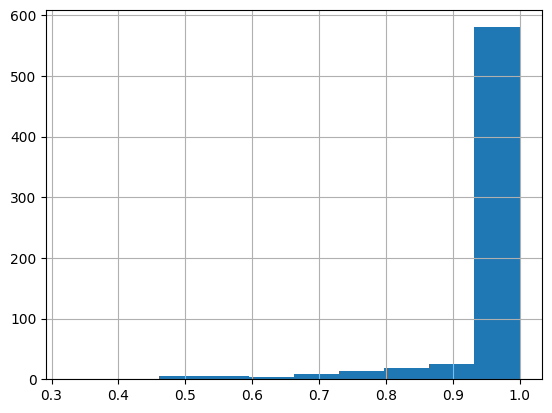

In [59]:
pred_df.score.hist()